In [1]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

import pandas as pd

# Pytorch
import torch
torch.manual_seed(29)
from torch import nn
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn.parallel
cudnn.benchmark = True
import torchvision.transforms as transforms

from twrap.utils import model_summary, tensor_to_torch_var
from utils.models import *
from torch.utils.data import DataLoader
from utils.datasets import dataset, test_dataset_visob, TestSampler2, test_dataset_2, test_dataset
from twrap.transform import ToZNorm

from twrap.utils import genROC

from torch.utils.data import Dataset

from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 12})

from glob import glob

from skimage import transform as T

from sklearn.metrics import roc_curve

import bcolz

from time import time
from twrap.utils import model_summary, parfilter, specifyLR, non_trainable_model, trainable_model, trainable_layer, AverageMeter

In [2]:
class dataset_feat(Dataset):
    def __init__(self, feat):

        self.feat   = feat

    def __getitem__(self, i):
        f = self.feat[i,...]
        return f
    def __len__(self):
        return self.feat.shape[0]

class dataset_bcolz(Dataset):
    def __init__(self, feat_1, locs_1, labels_1, feat_2, locs_2, labels_2):

        self.feat_1   = feat_1
        self.locs_1   = locs_1
        self.labels_1 = labels_1
        self.feat_2   = feat_2
        self.locs_2   = locs_2
        self.labels_2 = labels_2

    def __getitem__(self, ij):
        f1 = self.feat_1[ij[0],...]
        l1 = self.locs_1[ij[0],...]
        t1 = self.labels_1[ij[0]]
        
        f2 = self.feat_2[ij[1],...]
        l2 = self.locs_2[ij[1],...]
        t2 = self.labels_2[ij[1]]
        id2= ij[1]
        
        return f1, l1, t1, f2, l2, t2, str(id2)
    def __len__(self):
        return len(self.labels_1) * len(self.labels_2)

class bcolzsampler(object):
    def __init__(self, nb1, nb2, batch_size):

        self.nb1 = nb1
        self.nb2 = nb2
        self.batch_size = batch_size

    def __iter__(self):
        batch = []
        for i in range(self.nb1):
            for j in range(self.nb2):
                batch.append([i, j])
                if len(batch) == self.batch_size:
                    yield batch
                    batch = []
        if len(batch) > 0:
            yield batch

    def __len__(self):
        return (self.nb1 * self.nb2 + self.batch_size - 1) // self.batch_size


In [3]:
class localMatch(object):
    def __init__(self, w = 3, p = 70, cuda = True):
        
        self.w = w
        self.p = p
        c1 = np.zeros([w**2, 1, w, w], dtype = np.float32)
        c = 0
        for i in range(w):
            for j in range(w):
                c1[c, :, i, j] = 1
                c += 1
        c2 = np.zeros([1, 1, w, w], dtype = np.float32)
        c2[:, :, w//2, w//2] = 1
        
        self.c1 = torch.from_numpy(c1)
        self.c2 = torch.from_numpy(c2)
        
        if cuda:
            self.c1 = self.c1.cuda()
            self.c2 = self.c2.cuda()
    
    def __call__(self, I1, I1a, I2, I2a):
        
        I1ap = np.percentile(I1a.data.cpu().numpy(), self. p, axis = (1, 2, 3), keepdims = True)
        I2ap = np.percentile(I2a.data.cpu().numpy(), self. p, axis = (1, 2, 3), keepdims = True)
        
        I1ap = torch.from_numpy(I1ap).float().cuda()
        I2ap = torch.from_numpy(I2ap).float().cuda()
        
        I1a = (I1a > I1ap).float()
        I2a = (I2a > I2ap).float()
        
        b, f, h, w = I1.size()
        
        new_h = h - self.w + 1
        new_w = w - self.w + 1
        
        I1 = I1.view(b*f, 1, h, w)
        I1 = nn.functional.conv2d(I1, self.c2)
        I1 = I1.view(b, f, 1, new_h, new_w)
        
        I2 = I2.view(b*f, 1, h, w)
        I2 = nn.functional.conv2d(I2, self.c1)
        I2 = I2.view(b, f, self.w**2, new_h, new_w)
        
        
        I1a = nn.functional.conv2d(I1a, self.c2)
        I1a = I1a.view(b, 1, new_h, new_w)
        
        
        I2a = nn.functional.conv2d(I2a, self.c1)
        I2a = I2a.view(b, self.w**2, new_h, new_w)

        I1I2 = (I1 * I2).sum(1)
        I1aI2a = (I1a * I2a)
        
        I1I2 = torch.max(I1I2 * I1aI2a, dim = 1)[0]
        
        I1I2 = I1I2.view(b, -1).mean(1)
        
        return I1I2

class DenselocalMatch(object):
    def __init__(self, w = 3, p = 70, cuda = True):
        
        self.w = w
        self.p = p
        c1 = np.zeros([w**2, 1, w, w], dtype = np.float32)
        c = 0
        for i in range(w):
            for j in range(w):
                c1[c, :, i, j] = 1
                c += 1
        c2 = np.zeros([1, 1, w, w], dtype = np.float32)
        c2[:, :, w//2, w//2] = 1
        
        self.c1 = torch.from_numpy(c1)
        self.c2 = torch.from_numpy(c2)
        
        if cuda:
            self.c1 = self.c1.cuda()
            self.c2 = self.c2.cuda()
    
    def __call__(self, I1, I2):
        
        
        b, f, h, w = I1.size()
        
        new_h = h - self.w + 1
        new_w = w - self.w + 1
        
        I1 = I1.view(b*f, 1, h, w)
        I1 = nn.functional.conv2d(I1, self.c2)
        I1 = I1.view(b, f, 1, new_h, new_w)
        
        I2 = I2.view(b*f, 1, h, w)
        I2 = nn.functional.conv2d(I2, self.c1)
        I2 = I2.view(b, f, self.w**2, new_h, new_w)

        I1I2 = (I1 * I2).sum(1)
        
        I1I2 = torch.max(I1I2, dim = 1)[0]
        
        I1I2 = I1I2.view(b, -1).mean(1)
        
        return I1I2

In [4]:
data_fldr = '/media/narsi/LargeData/ocularnetv2_2019_SUMMER'
dst_fldr = '/media/narsi/LargeData/ocularnetv2_2019_SUMMER/SCORES_W20'

visit1 = 'EC_VISIT_1'
visit2 = 'EC_VISIT_1'
device = 'IPHONE'
light_enroll = 'office'
light_verify = 'office'
eye = 'l'

In [5]:

feat_1 = np.load(data_fldr + os.sep + visit1 + os.sep + device + os.sep + light_enroll +  os.sep + 'S1' + '_' +  eye + os.sep + 'feat20.npy')
locs_1 = np.load(data_fldr + os.sep + visit1 + os.sep + device + os.sep + light_enroll +  os.sep + 'S1' + '_' +  eye + os.sep + 'locs20.npy')

feat_2 = np.load(data_fldr + os.sep + visit2 + os.sep + device + os.sep + light_verify +  os.sep + 'S2' + '_' +  eye + os.sep + 'feat20.npy')
locs_2 = np.load(data_fldr + os.sep + visit2 + os.sep + device + os.sep + light_verify +  os.sep + 'S2' + '_' +  eye + os.sep + 'locs20.npy')

labels_1 = np.load(data_fldr + os.sep + visit1 + os.sep + device + os.sep + light_enroll +  os.sep + 'S1' + '_' +  eye + os.sep + 'labels.npy')
labels_2 = np.load(data_fldr + os.sep + visit2 + os.sep + device + os.sep + light_verify +  os.sep + 'S2' + '_' +  eye + os.sep + 'labels.npy')


dsbz = dataset_bcolz(feat_1, locs_1, labels_1, feat_2, locs_2, labels_2)
DB = bcolzsampler(len(dsbz.labels_1), len(dsbz.labels_2), 128)
DL = DataLoader(dsbz, num_workers=8, pin_memory=True, shuffle = False, batch_sampler=DB)

LM = localMatch(w = 5, p = 70, cuda = True)

scores = []
attens = []
enroll = []
verify = []
vid = []

# gen_hist_dist = np.zeros((len(x)-1, ))
# imp_hist_dist = np.zeros((len(x)-1, ))

for (f1, l1, t1, f2, l2, t2, id2) in tqdm(DL):
    s = LM(f1.cuda(), l1.cuda(), f2.cuda(), l2.cuda())
    
    scores.append(s.data.cpu().numpy())
    enroll += t1
    verify += t2
    vid += id2
    
    del f1, l1, t1, f2, l2, t2, id2, s

scores = np.expand_dims(np.concatenate(scores), 1)
enroll = np.expand_dims(np.asarray(enroll, dtype = str), 1)
verify = np.expand_dims(np.asarray(verify, dtype = str), 1)
vid = np.expand_dims(np.asarray(vid, dtype = str), 1)

100%|██████████| 96014/96014 [1:41:58<00:00, 15.69it/s]


In [ ]:
csv_file_dst = '/media/narsi/LargeData/ocularnetv2_2019_SUMMER/scores_W20'

scores = np.concatenate((enroll, verify, scores, vid), axis = 1)

np.save(csv_file_dst + os.sep + 'DEVICE::'+device +'ENROLL::'+visit1+light_enroll+'__' + 'VERIFY::'+visit2+light_verify+'__EYE'+eye, scores)

In [6]:
import pandas as pd

 38%|███▊      | 36948/96014 [38:20<1:03:34, 15.48it/s]

In [7]:
csv_file_dst = '/media/narsi/LargeData/ocularnetv2_2019_SUMMER/scores_W20'
A = np.load(csv_file_dst + os.sep + 'DEVICE::'+device +'ENROLL::'+visit1+light_enroll+'__' + 'VERIFY::'+visit2+light_verify+'__EYE'+eye+'.npy')
A = pd.DataFrame(A, columns=['enroll', 'verify', 'scores', 'vid'])

In [8]:
A = pd.DataFrame(scores, columns=['enroll', 'verify', 'scores', 'vid'])

In [7]:
scores = np.expand_dims(np.concatenate(scores), 1)
enroll = np.expand_dims(np.asarray(enroll, dtype = str), 1)
verify = np.expand_dims(np.asarray(verify, dtype = str), 1)
vid = np.expand_dims(np.asarray(vid, dtype = str), 1)
scores = np.concatenate((enroll, verify, scores, vid), axis = 1)

In [9]:
S = A.groupby(['enroll', 'verify', 'vid']).agg(np.max)

In [10]:
mts = np.float32(S['scores'])
mtt = np.asarray([1 * (x[0] == x[1]) for x in list(S['scores'].index.values)])
mt_e = np.asarray([x[0] for x in list(S['scores'].index.values)])
mt_v = np.asarray([x[1] for x in list(S['scores'].index.values)])
mt_vid = np.asarray([x[2] for x in list(S['scores'].index.values)])

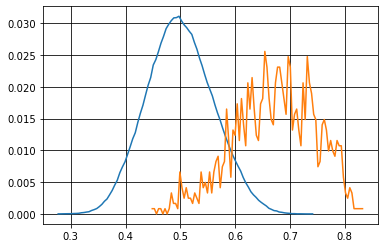

In [11]:
x1 = plt.hist(mts[mtt == 0], bins = 100)
x2 = plt.hist(mts[mtt == 1], bins = 100)
plt.close()

plt.plot(x1[1][1:], x1[0]/np.sum(x1[0]))
plt.plot(x2[1][1:], x2[0]/np.sum(x2[0]))
plt.grid(b=True, which='major', color='k', linestyle='-')

In [12]:
cmc_50 = np.zeros(shape=(150, ), dtype=np.float64)
count = 0
for vid in tqdm(list(np.unique(mt_vid))):
    
    s = mts[mt_vid == vid]
    t = mtt[mt_vid == vid]

    if np.sum(t) != 0:
        locs = np.argsort(-1 * s)
        t_50 = t[locs[:150]]
        t_50 = np.cumsum(t_50)
        t_50[t_50 >= 1] = 1
        cmc_50 += t_50
        count+=1


 83%|████████▎ | 2560/3084 [00:15<00:02, 179.07it/s]


100%|██████████| 3084/3084 [00:18<00:00, 170.66it/s]

Text(0.5, 1.0, 'RANK - 1: 76.75% RANK - 5: 84.34 %')

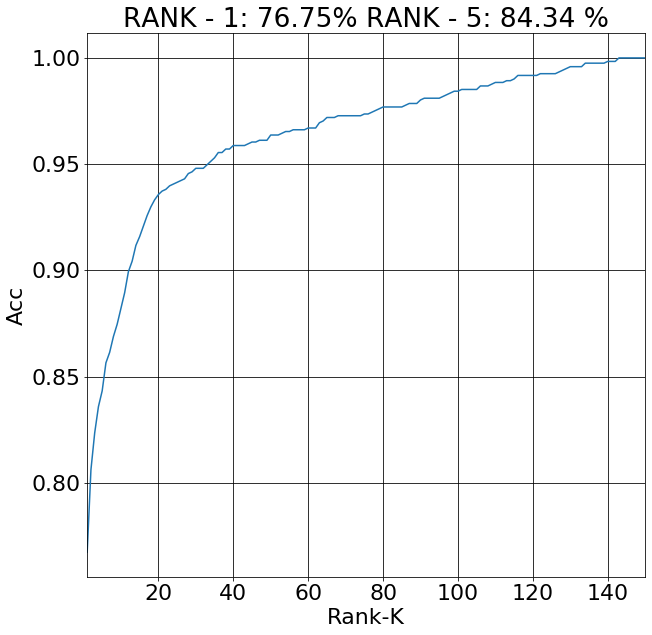

In [13]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(10, 10))
plt.plot(np.arange(1, 151), cmc_50/count)
plt.xlim([1, 150])
plt.xlabel('Rank-K')
plt.ylabel('Acc')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.title('RANK - 1: ' + '{0:0.2f}'.format(cmc_50[0] * 100/count) + '% RANK - 5: ' + '{0:0.2f}'.format(cmc_50[4] * 100/count) + ' %')

In [14]:
targets = 1 * (np.asarray(A['enroll']) == np.asarray(A['verify']))
scores = np.float32(A['scores'])

In [14]:
scores

array([0.21893989, 0.22875854, 0.23945345, ..., 0.56912565, 0.5527713 ,
       0.54118294], dtype=float32)

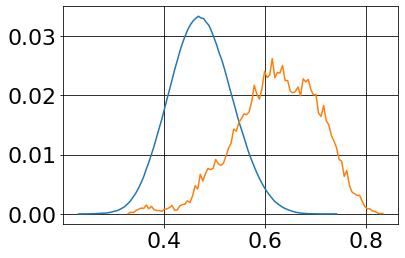

In [15]:
x1 = plt.hist(scores[targets == 0], bins = 100)
x2 = plt.hist(scores[targets == 1], bins = 100)
plt.close()

plt.plot(x1[1][1:], x1[0]/np.sum(x1[0]))
plt.plot(x2[1][1:], x2[0]/np.sum(x2[0]))
plt.grid(b=True, which='major', color='k', linestyle='-')

Text(0.5, 1.0, 'RANK - 1: 76.75% RANK - 10: 88.21 %')

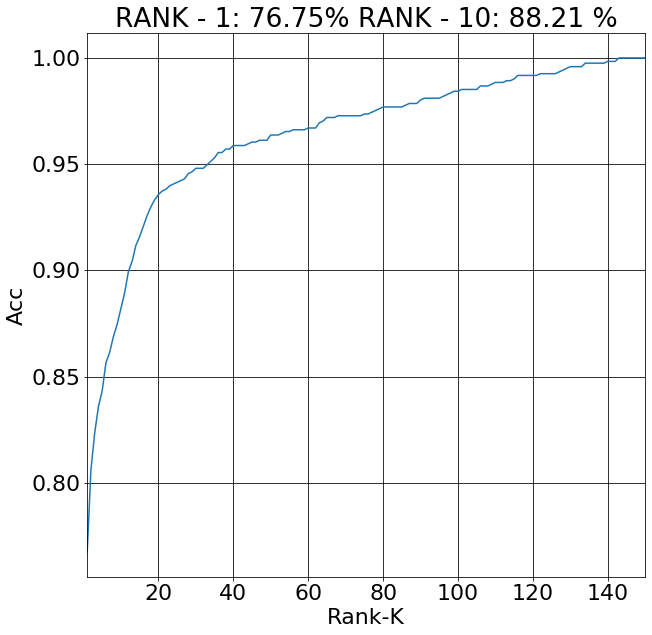

In [16]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(10, 10))
plt.plot(np.arange(1, 151), cmc_50/count)
plt.xlim([1, 150])
plt.xlabel('Rank-K')
plt.ylabel('Acc')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.title('RANK - 1: ' + '{0:0.2f}'.format(cmc_50[0] * 100/count) + '% RANK - 10: ' + '{0:0.2f}'.format(cmc_50[9] * 100/count) + ' %')

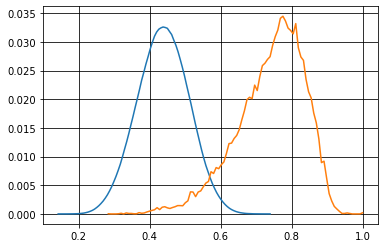

In [103]:
targets = 1 * (enroll == verify)

x1 = plt.hist(scores[targets == 0], bins = 100)
x2 = plt.hist(scores[targets == 1], bins = 100)
plt.close()

plt.plot(x1[1][1:], x1[0]/np.sum(x1[0]))
plt.plot(x2[1][1:], x2[0]/np.sum(x2[0]))
plt.grid(b=True, which='major', color='k', linestyle='-')

Text(0.5, 1.0, 'GMR @ 0.001 FMR 36.72%')

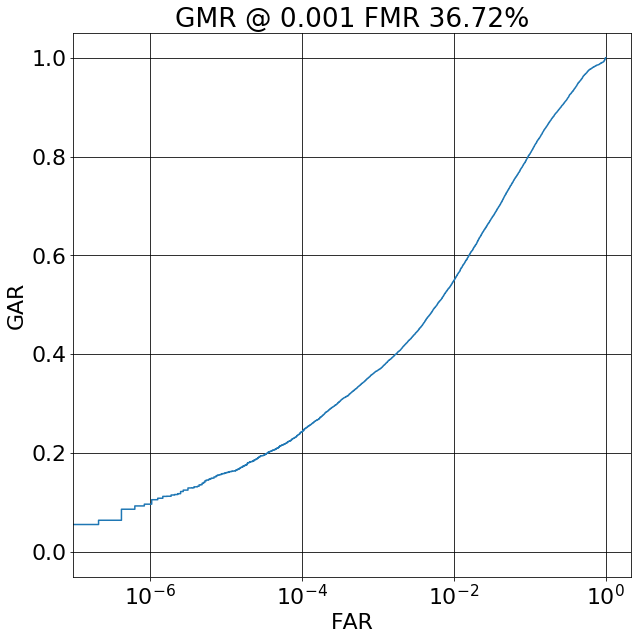

In [17]:
plt.figure(figsize=(10, 10))
far, tar, _ = roc_curve(targets, scores)
plt.semilogx(far, tar)
plt.xlabel('FAR')
plt.ylabel('GAR')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='r', linestyle='--')
plt.title('GMR @ 0.001 FMR ' + '{0:0.2f}'.format(np.min(tar[far>= 0.001] * 100)) + '%')

Text(0.5, 1.0, 'GMR @ 0.001 FMR 48.31%')

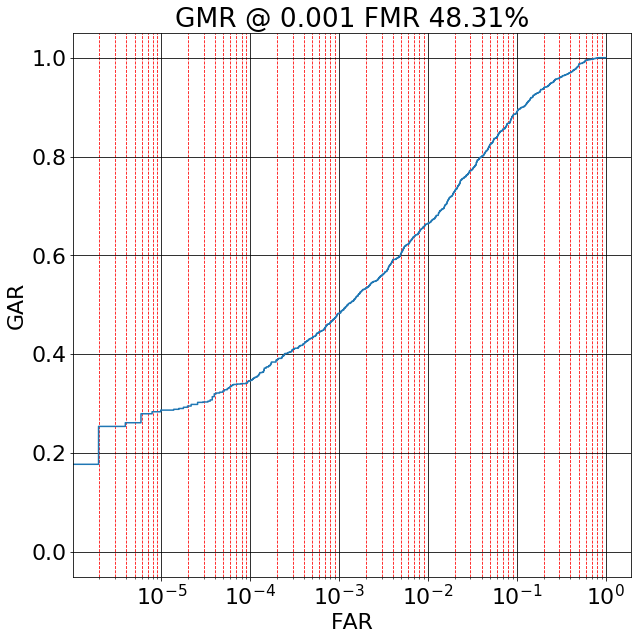

In [18]:
plt.figure(figsize=(10, 10))
far, tar, _ = roc_curve(mtt, mts)
plt.semilogx(far, tar)
plt.xlabel('FAR')
plt.ylabel('GAR')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='r', linestyle='--')
plt.title('GMR @ 0.001 FMR ' + '{0:0.2f}'.format(np.min(tar[far>= 0.001] * 100)) + '%')